In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression


In [14]:
# ---------- Config ----------
DATA_PATH = "university_admission.csv"   # change if your file is elsewhere
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
RANDOM_STATE = 42
# ----------------------------

# 1) Load dataset
df = pd.read_csv(DATA_PATH)
print("Loaded dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isnull().sum())

target_col = "admission_chance"

Loaded dataset shape: (500, 9)
Columns: ['Serial No.', 'pre_term_test', 'final_term_test', 'university_rating', 'sop_strength', 'lor_score', 'cgpa', 'has_research_exp', 'admission_chance']

Missing values per column:
 Serial No.           0
pre_term_test        0
final_term_test      0
university_rating    0
sop_strength         0
lor_score            0
cgpa                 0
has_research_exp     0
admission_chance     0
dtype: int64


In [15]:
# 3) Define features (drop any ID-like columns if present)
# Remove obvious ID column name 'Serial No.' if present
df_clean = df.copy()
if 'Serial No.' in df_clean.columns:
    df_clean = df_clean.drop(columns=['Serial No.'])
features = [c for c in df_clean.columns if c != target_col]
print("Feature columns:", features)

# 4) Separate numeric & categorical features
numeric_features = df_clean[features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in features if c not in numeric_features]
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# 5) Outlier treatment (IQR capping) on numeric columns
#    We'll cap at lower/upper fences (1.5 * IQR)
df_out = df_clean.copy()
for col in numeric_features:
    q1 = df_out[col].quantile(0.25)
    q3 = df_out[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df_out[col] = np.where(df_out[col] < lower, lower, df_out[col])
    df_out[col] = np.where(df_out[col] > upper, upper, df_out[col])

# 6) Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)


Feature columns: ['pre_term_test', 'final_term_test', 'university_rating', 'sop_strength', 'lor_score', 'cgpa', 'has_research_exp']
Numeric features: ['pre_term_test', 'final_term_test', 'university_rating', 'sop_strength', 'lor_score', 'cgpa', 'has_research_exp']
Categorical features: []


In [16]:
# 7) Prepare X, y and transform (we'll need transformed feature names for SelectKBest)
X = df_out[features].copy()
y = df_out[target_col].copy()

# Fit preprocessor to get transformed feature matrix
X_transformed = preprocessor.fit_transform(X)
print("Transformed feature matrix shape:", X_transformed.shape)

# build transformed feature names (numeric + one-hot names)
feature_names = []
feature_names.extend(numeric_features)
if categorical_features:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    try:
        ohe_names = list(ohe.get_feature_names_out(categorical_features))
    except Exception:
        # fallback if older sklearn
        ohe_names = []
        # best-effort name building
        for i, col in enumerate(categorical_features):
            categories = ohe.categories_[i]
            ohe_names.extend([f"{col}_{cat}" for cat in categories])
    feature_names.extend(ohe_names)

print("Final feature count after preprocessing:", len(feature_names))

# 8) Feature selection (SelectKBest using f_regression). Choose top k features.
k = min(5, X_transformed.shape[1])  # choose up to 5 features (as example)
selector = SelectKBest(score_func=f_regression, k=k)
selector.fit(X_transformed, y)
mask = selector.get_support()
selected_features = [feature_names[i] for i, m in enumerate(mask) if m]
print("Selected top features:", selected_features)

# Build selected X for modeling
X_selected = X_transformed[:, mask]

Transformed feature matrix shape: (500, 7)
Final feature count after preprocessing: 7
Selected top features: ['pre_term_test', 'final_term_test', 'university_rating', 'sop_strength', 'cgpa']


In [17]:
# 9) Helper: evaluate model (train/test split + CV)
def evaluate_model(model, X, y, model_name="model"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # 5-fold cross-val RMSE (use neg_root_mean_squared_error scoring)
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_rmse = -cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
    return {
        "model_name": model_name,
        "model_obj": model,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "cv_rmse": cv_rmse,
        "y_test": y_test.reset_index(drop=True),
        "y_pred": pd.Series(y_pred)
    }

# 10) Instantiate models
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=RANDOM_STATE)
}

# 11) Train & evaluate
results = []
for name, model in models.items():
    print(f"\nTraining & evaluating: {name}")
    res = evaluate_model(model, X_selected, y, model_name=name)
    results.append(res)
    print(f"{name} -> RMSE: {res['rmse']:.4f}, MAE: {res['mae']:.4f}, R2: {res['r2']:.4f}, CV_RMSE: {res['cv_rmse']:.4f}")

# 12) Summarize results
summary_df = pd.DataFrame([{
    "model": r["model_name"],
    "rmse": r["rmse"],
    "mae": r["mae"],
    "r2": r["r2"],
    "cv_rmse": r["cv_rmse"]
} for r in results]).sort_values("cv_rmse")
print("\nModel summary:\n", summary_df)



Training & evaluating: LinearRegression
LinearRegression -> RMSE: 0.0629, MAE: 0.0439, R2: 0.8065, CV_RMSE: 0.0621

Training & evaluating: RandomForest


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RandomForest -> RMSE: 0.0666, MAE: 0.0444, R2: 0.7834, CV_RMSE: 0.0669

Training & evaluating: GradientBoosting


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


GradientBoosting -> RMSE: 0.0689, MAE: 0.0473, R2: 0.7681, CV_RMSE: 0.0681

Model summary:
               model      rmse       mae        r2   cv_rmse
0  LinearRegression  0.062910  0.043871  0.806469  0.062078
1      RandomForest  0.066559  0.044417  0.783367  0.066914
2  GradientBoosting  0.068872  0.047336  0.768050  0.068128


Saved model summary to: output\model_results_summary.csv

Best model by CV RMSE: LinearRegression


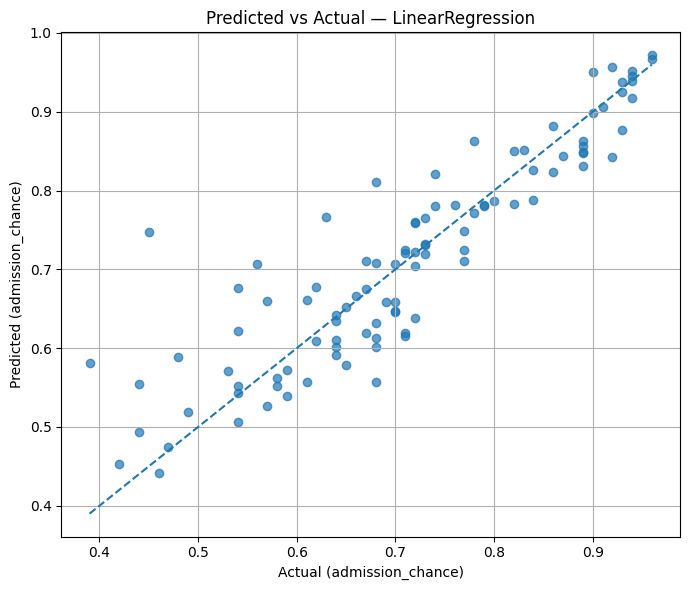

Saved predicted vs actual plot to: output\predicted_vs_actual.png


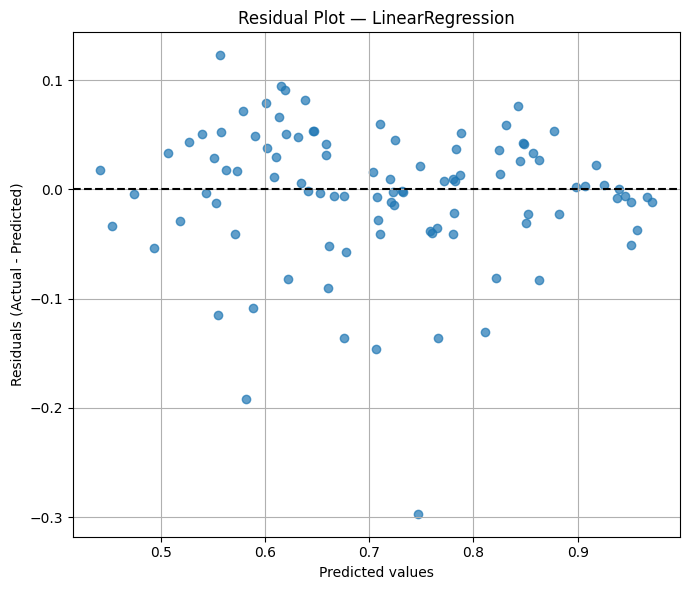

Saved residual plot to: output\residuals_plot.png


In [18]:
# Save summary CSV
summary_csv_path = os.path.join(OUTPUT_DIR, "model_results_summary.csv")
summary_df.to_csv(summary_csv_path, index=False)
print("Saved model summary to:", summary_csv_path)

# 13) Choose best model by cv_rmse and plot diagnostics
best = min(results, key=lambda x: x["cv_rmse"])
print("\nBest model by CV RMSE:", best["model_name"])

y_test = best["y_test"]
y_pred = best["y_pred"]

# Predicted vs Actual scatter
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--')  # 45-degree
plt.xlabel(f"Actual ({target_col})")
plt.ylabel(f"Predicted ({target_col})")
plt.title(f"Predicted vs Actual — {best['model_name']}")
plt.grid(True)
plt.tight_layout()
pred_vs_actual_path = os.path.join(OUTPUT_DIR, "predicted_vs_actual.png")
plt.savefig(pred_vs_actual_path)
plt.show()
print("Saved predicted vs actual plot to:", pred_vs_actual_path)

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(7,6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, linestyle='--', color='black')
plt.xlabel("Predicted values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title(f"Residual Plot — {best['model_name']}")
plt.grid(True)
plt.tight_layout()
residuals_path = os.path.join(OUTPUT_DIR, "residuals_plot.png")
plt.savefig(residuals_path)
plt.show()
print("Saved residual plot to:", residuals_path)


In [ ]:







# (Optional) Save best model using pickle
try:
    import joblib
    model_out_path = os.path.join(OUTPUT_DIR, f"best_model_{best['model_name']}.pkl")
    joblib.dump(best["model_obj"], model_out_path)
    print("Saved best model to:", model_out_path)
except Exception as e:
    print("Could not save model with joblib (not installed?), error:", e)

# 14) Print selected features (human readable)
print("\nTop selected features used for modeling (after preproc):")
for f in selected_features:
    print(" -", f)

# Done
print("\nPipeline finished. Outputs are in:", OUTPUT_DIR)
